In [ ]:
# !pip install tensorflow==2.13.0
# !pip install ultralytics
# !pip install tf2onnx
# !pip install onnx
# !pip install onnxruntime
# !pip install streamlit pyngrok

#### Combining Efficient Net & Yolo

##### Load Trained EfficientNet

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
# Load the EfficientNet B0 model with custom_objects
model_path = '/content/efficientNet_fire_classifier.h5'
efficientnet_model = load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

##### Load Trained YOLOv8

In [ ]:
from ultralytics import YOLO

model_path= '/content/best.pt'
# Load the YOLO model
yolov8_model = YOLO(model_path)

##### Inference

1/1 [==============================] - 0s 81ms/step

0: 640x640 2 Fires, 1632.6ms
Speed: 6.1ms preprocess, 1632.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


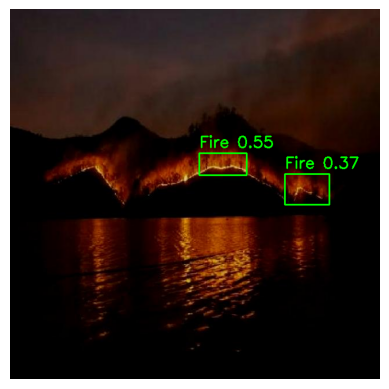

Detected objects in /content/abc.jpg: {0: 'Fire'}
Original shape: (640, 640)
Path: image0.jpg
Save directory: runs/detect/predict
Speed: {'preprocess': 6.117582321166992, 'inference': 1632.5719356536865, 'postprocess': 1.0628700256347656}
1/1 [==============================] - 0s 76ms/step

0: 448x640 2 Fires, 1106.0ms
Speed: 3.0ms preprocess, 1106.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


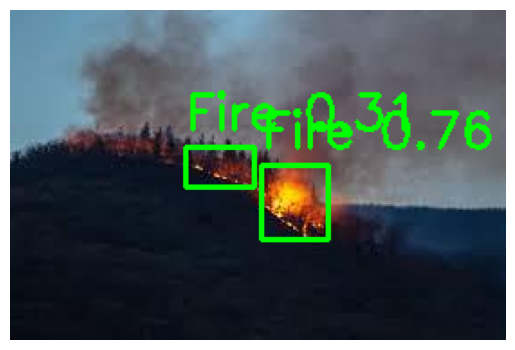

Detected objects in /content/xyz.jpg: {0: 'Fire'}
Original shape: (183, 275)
Path: image0.jpg
Save directory: runs/detect/predict
Speed: {'preprocess': 2.99835205078125, 'inference': 1106.0149669647217, 'postprocess': 0.9582042694091797}


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Class labels for the EfficientNet model
class_labels = ['nofire', 'smoke', 'fire']

def preprocess_image(img_path):
    """Preprocess the image for EfficientNet."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

def classify_image(model, img_array):
    """Classify the image using EfficientNet."""
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    return predicted_class, predictions

def filter_and_detect(efficientnet_model, yolov8_model, img_paths):
    """Filter images using EfficientNet and detect objects using YOLOv8."""
    for img_path in img_paths:
        # Preprocess the image
        img_array = preprocess_image(img_path)

        # Classify the image
        predicted_class, _ = classify_image(efficientnet_model, img_array)
        class_label = class_labels[predicted_class[0]]

        # If the image is classified as "fire" or "smoke", forward it to YOLOv8
        if class_label in ['smoke', 'fire']:
            # Load the image for YOLOv8
            img = cv2.imread(img_path)

            # Run YOLOv8 detection
            results = yolov8_model(img)

            # Process and display results
            for result in results:
                # Draw bounding boxes on the image
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    label = result.names[int(box.cls)]
                    confidence = float(box.conf)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                # Convert the image to RGB format for displaying with matplotlib
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()

                # Print the relevant information
                print(f"Detected objects in {img_path}: {result.names}")
                print(f"Original shape: {result.orig_shape}")
                print(f"Path: {result.path}")
                print(f"Save directory: {result.save_dir}")
                print(f"Speed: {result.speed}")
        else:
            print(f"Image {img_path} classified as 'nofire', skipping detection.")

# List of image paths to process
img_paths = [
    "/content/abc.jpg",
    # "/content/nofire.jpg",
    "/content/xyz.jpg"
    # Add more image paths as needed
]

# Assuming you have the EfficientNet model loaded as `efficientnet_model`
# and the YOLOv8 model loaded as `yolov8_model`
filter_and_detect(efficientnet_model, yolov8_model, img_paths)

#### Streamlit App

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the EfficientNet B0 model with custom_objects
model_path = '/content/efficientNet_fire_classifier.h5'
efficientnet_model = load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

# Load the YOLO model
yolov8_model_path = '/content/best.pt'
yolov8_model = YOLO(yolov8_model_path)

# Class labels for the EfficientNet model
class_labels = ['nofire', 'smoke', 'fire']

def preprocess_image(img):
    """Preprocess the image for EfficientNet."""
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

def classify_image(model, img_array):
    """Classify the image using EfficientNet."""
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    return predicted_class, predictions

def filter_and_detect(efficientnet_model, yolov8_model, img):
    """Filter images using EfficientNet and detect objects using YOLOv8."""
    # Preprocess the image
    img_array = preprocess_image(img)

    # Classify the image
    predicted_class, _ = classify_image(efficientnet_model, img_array)
    class_label = class_labels[predicted_class[0]]

    # If the image is classified as "fire" or "smoke", forward it to YOLOv8
    if class_label in ['smoke', 'fire']:
        # Convert PIL image to OpenCV format
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        # Run YOLOv8 detection
        results = yolov8_model(img_cv)

        # Process and display results
        for result in results:
            # Draw bounding boxes on the image
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                label = result.names[int(box.cls)]
                confidence = float(box.conf)
                cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_cv, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Convert the image to RGB format for displaying with matplotlib
        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        return img_rgb, class_label
    else:
        return None, class_label

# Streamlit app
st.title("Fire and Smoke Detection")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    # Read the uploaded image
    img = Image.open(uploaded_file)

    # Display the uploaded image
    st.image(img, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    # Filter and detect
    result_img, class_label = filter_and_detect(efficientnet_model, yolov8_model, img)

    if result_img is not None:
        st.image(result_img, caption=f'Detected {class_label}', use_column_width=True)
    else:
        st.write(f"Image classified as '{class_label}', skipping detection.")

Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Run the Streamlit app
!streamlit run app.py &

# Expose the Streamlit app to the web
public_url = ngrok.connect(port='8501')
print(f"Streamlit app is live at: {public_url}")




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.236.42:8501

  Stopping...


ERROR:pyngrok.process.ngrok:t=2024-09-10T12:28:47+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2024-09-10T12:28:47+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

#### Conversion ONNX Model

##### Efficient Net

In [ ]:
import tf2onnx

# Convert the EfficientNet model to ONNX
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32),)
output_path = "/content/efficientnet_model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(efficientnet_model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print(f"Model has been converted to ONNX and saved at {output_path}")

##### YOLOv8

In [ ]:
import torch

# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(1, 3, 640, 640)  # Adjust the input size as needed

# Define the output path for the ONNX model
output_path = "/content/yolov8_model.onnx"

# Convert the YOLOv8 model to ONNX
torch.onnx.export(yolov8_model.model, dummy_input, output_path, opset_version=13)

print(f"Model has been converted to ONNX and saved at {output_path}")

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/head.py:92: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.shape != shape:
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/tal.py:308: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


Model has been converted to ONNX and saved at /content/yolov8_model.onnx


#### Combining Both ONNX Models

##### Loading And Testing EfficientNet ONNX

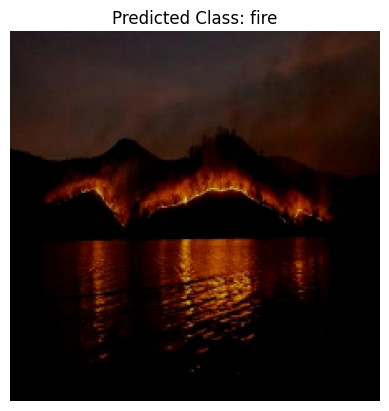

In [ ]:
import onnxruntime as ort
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the EfficientNet ONNX model
efficientnet_model_path = "/content/efficientnet_model.onnx"
session = ort.InferenceSession(efficientnet_model_path)

def preprocess_image(img_path):
    """Preprocess the image for EfficientNet."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array, img

# Load and preprocess the image
img_path = "/content/abc.jpg"
img_array, original_img = preprocess_image(img_path)

# Run inference
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
results = session.run([output_name], {input_name: img_array.astype(np.float32)})

# Class labels for the EfficientNet model
class_labels = ['nofire', 'smoke', 'fire']

# Get the predicted class
predicted_class = np.argmax(results[0], axis=-1)
predicted_label = class_labels[predicted_class[0]]

# Display the image with the predicted class label
plt.imshow(original_img)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis('off')
plt.show()

# print(f"Predicted class: {predicted_label}")

##### Loading And Testing YOLOv8 ONNX

Input image shape: (1, 3, 640, 640)
Input image sample values: [[[    0.37255     0.37255     0.37255     0.37255     0.37255]
  [    0.37255     0.37255     0.37255     0.37255     0.37255]
  [    0.37255     0.37255     0.37255     0.37255     0.37255]
  [    0.37255     0.37255     0.37255     0.37255     0.37255]
  [    0.37255     0.37255     0.37255     0.37255     0.37255]]

 [[    0.55294     0.55294     0.55294     0.55294     0.55294]
  [    0.55294     0.55294     0.55294     0.55294     0.55294]
  [    0.55294     0.55294     0.55294     0.55294     0.55294]
  [    0.55294     0.55294     0.55294     0.55294     0.55294]
  [    0.55294     0.55294     0.55294     0.55294     0.55294]]

 [[     0.6549      0.6549      0.6549      0.6549      0.6549]
  [     0.6549      0.6549      0.6549      0.6549      0.6549]
  [     0.6549      0.6549      0.6549      0.6549      0.6549]
  [     0.6549      0.6549      0.6549      0.6549      0.6549]
  [     0.6549      0.6549      0.654

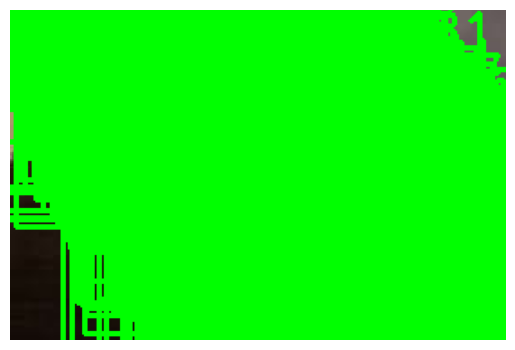

In [ ]:
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the YOLOv8 ONNX model
yolov8_model_path = "/content/yolov8_model.onnx"
session = ort.InferenceSession(yolov8_model_path)

def preprocess_image(img_path):
    """Preprocess the image for YOLOv8."""
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image file not found at {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (640, 640))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = img_array.astype(np.float32) / 255.0
    img_array = np.transpose(img_array, (0, 3, 1, 2))  # Change shape to [1, 3, 640, 640]
    return img_array, img

# Load and preprocess the image
img_path = "/content/xyz.jpg"
img_array, original_img = preprocess_image(img_path)

# Verify the input image dimensions and normalization
print("Input image shape:", img_array.shape)
print("Input image sample values:", img_array[0, :, :5, :5])  # Print a small sample of the input image

# Run inference
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
results = session.run([output_name], {input_name: img_array})

# Inspect the results array
print("Results shape:", results[0].shape)
print("Results sample:", results[0][:5])  # Print the first 5 results for inspection

def postprocess_results(results, img_shape, conf_threshold=0.5):
    """Postprocess the results to extract bounding boxes and labels."""
    predictions = results[0].reshape(-1, 5)  # Reshape to (8400, 5)
    boxes = []
    scores = []
    labels = []

    for pred in predictions:
        x, y, w, h, confidence = pred
        if confidence > conf_threshold:
            # Convert from center x, y, width, height to x1, y1, x2, y2
            x1 = (x - w / 2) * img_shape[1] / 640
            y1 = (y - h / 2) * img_shape[0] / 640
            x2 = (x + w / 2) * img_shape[1] / 640
            y2 = (y + h / 2) * img_shape[0] / 640
            boxes.append([x1, y1, x2, y2])
            scores.append(confidence)
            labels.append(0)  # Assuming single class (Fire)

    return np.array(boxes), np.array(scores), np.array(labels)

# Postprocess the results
boxes, scores, labels = postprocess_results(results, original_img.shape)

# Debugging: Print the bounding boxes, scores, and labels
print("Bounding boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)

def display_image_with_boxes(img, boxes, scores, labels, class_names):
    """Display the image with bounding boxes and labels."""
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{class_names[label]} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert the image to RGB format for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Class labels for YOLOv8 model
class_names = {0: 'Fire'}  # Update with your actual class names

# Display the image with bounding boxes
display_image_with_boxes(original_img, boxes, scores, labels, class_names)

In [ ]:
import onnx.helper as helper
import onnx.numpy_helper as numpy_helper

# Create a new ONNX graph
graph = helper.make_graph(
    nodes=[],
    name="EfficientNet_YOLOv8",
    inputs=[],
    outputs=[]
)

# Add EfficientNet nodes and initializers to the graph
for node in efficientnet_model.graph.node:
    graph.node.append(node)
for initializer in efficientnet_model.graph.initializer:
    graph.initializer.append(initializer)

# Add YOLOv8 nodes and initializers to the graph
for node in yolov8_model.graph.node:
    graph.node.append(node)
for initializer in yolov8_model.graph.initializer:
    graph.initializer.append(initializer)

# Define the input and output tensors for the combined model
input_tensor = helper.make_tensor_value_info("input", onnx.TensorProto.FLOAT, [1, 3, 224, 224])
efficientnet_output_tensor = efficientnet_model.graph.output[0]
yolov8_input_tensor = yolov8_model.graph.input[0]
output_tensor = helper.make_tensor_value_info("output", onnx.TensorProto.FLOAT, [1, 3, 640, 640])

# Connect EfficientNet output to YOLOv8 input
efficientnet_output_name = efficientnet_output_tensor.name
yolov8_input_name = yolov8_input_tensor.name
for node in graph.node:
    for i, input_name in enumerate(node.input):
        if input_name == yolov8_input_name:
            node.input[i] = efficientnet_output_name

# Add the input and output tensors to the graph
graph.input.append(input_tensor)
graph.output.append(output_tensor)

# Create the combined ONNX model
combined_model = helper.make_model(graph, producer_name="EfficientNet_YOLOv8")

# Save the combined ONNX model
onnx.save(combined_model, "/content/combined_model.onnx")

##### Inference On Combined ONNX Model

In [ ]:
import onnxruntime as ort
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the combined ONNX model
combined_model_path = "/content/combined_model.onnx"
session = ort.InferenceSession(combined_model_path)

def preprocess_image(img_path):
    """Preprocess the image for EfficientNet."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Load and preprocess the image
img_path = "/content/nofire.jpg"
img_array = preprocess_image(img_path)

# Run inference
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
results = session.run([output_name], {input_name: img_array.astype(np.float32)})

def postprocess_and_display(results, img_path):
    """Postprocess the results and display the image with bounding boxes."""
    # Load the original image
    img = cv2.imread(img_path)

    # Extract the bounding boxes and labels from the results
    # This part depends on the specific output format of your combined model
    # For demonstration, let's assume the results contain bounding boxes and labels
    bounding_boxes = results[0]  # Replace with actual extraction logic
    labels = results[1]  # Replace with actual extraction logic

    # Draw bounding boxes on the image
    for box, label in zip(bounding_boxes, labels):
        x1, y1, x2, y2 = map(int, box[:4])
        confidence = box[4]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert the image to RGB format for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Postprocess and display the results
postprocess_and_display(results, img_path)

Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from /content/combined_model.onnx failed:/onnxruntime_src/onnxruntime/core/graph/graph.cc:1431 void onnxruntime::Graph::InitializeStateFromModelFileGraphProto() This is an invalid model. Graph output (output) does not exist in the graph.
